# Coding Assignment 3

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Data

In [ ]:
# Load the dataset
(dataset_train, dataset_test), dataset_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)



In [ ]:
# visualize 9 images.
### No EDITS needed in this code block if previous block ran ###

plt.figure(figsize=(9, 9))
for i, (image, label) in enumerate(dataset_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(int(label))
    plt.axis("off")

# MLP 

First develop an MLP model. Since the images are represented by 2D matrices, it will be necessary to reshape each image to
a 1D array (so, overall, the dataset is of shape (len(data), 300*300). But we want to reduce the complexity, especially since the MLP is not ideal for this and we are generating a large, 1D array when flattening. 

In [6]:
### No EDITS needed in this code block if previous block ran. This is educational ###

def preprocess_and_flatten(image, label):
    image = tf.image.resize(image, [150, 150])
    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)
    # Normalize the image
    image = tf.cast(image, tf.float32) / 255.0
    # Flatten the image to a 1D tensor
    image = tf.reshape(image, [-1])
    return image, label

# Apply the preprocessing function to the dataset
mlp_train = dataset_train.map(preprocess_and_flatten)
mlp_test = dataset_test.map(preprocess_and_flatten)

# Batch and prefetch the dataset for optimal performance. The prefetch is relevent when working with lage datasets
# as expensive processing hardware must be used to perform the matrix operations and should be used optimally. GPUs or TPUs 
# should not run idle once the training has begun. The method for retreiving the data, then, becomes very important
# and this consideration is less relevant with the smaller datasets we have worked with at this point.But I wanted to
# show that this is essential in the real world of big data, and here we're creating a scenario that's artificially making
# the data bigger and suboptimal for demonstration. We will balance this out a bit with the following code:

# use this data for the mlp #
BATCH_SIZE = 32
mlp_train = mlp_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
mlp_test = mlp_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build an MLP Model that Computes an Appropriate Performance Metric

In [7]:
from tensorflow.keras.metrics import AUC

model_mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(22500,)),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

    ### EDIT Needed, add layers including a suitable output layer, given the number of classes (e.g. 3)
    ### EDIT Needed

model_mlp.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])# EDITS Needed])

history = model_mlp.fit(
    mlp_train,
    epochs=5,  # You can adjust the number of epochs
    validation_data=mlp_test,

)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4698 - loss: 4.1533 - val_accuracy: 0.4812 - val_loss: 0.9678
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7393 - loss: 0.6513 - val_accuracy: 0.4382 - val_loss: 1.0413
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8440 - loss: 0.4237 - val_accuracy: 0.4301 - val_loss: 1.4740
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8841 - loss: 0.3267 - val_accuracy: 0.4919 - val_loss: 1.4663
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9369 - loss: 0.2147 - val_accuracy: 0.4704 - val_loss: 1.7737


### Plot Training/Validation Performance Curves and Describe Result

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Description: The accuracy of training set predictions consistently improves as the ANN trains. But when measuring accuracy on the validation the model is basically 50/50, which suggests that in the real world the model probably wouldn't get the answers right more than half the time. And accuracy on the validation doesn't get better the more it trains. Not a very informative model as it stands.







# Build a CNN Model that Computes an Appropiate Performance Metric

Now, see if using image specific layers,for instance, the Conv2D, improve the classification performance

In [8]:

# Basic preprocessing: Resize images and normalize
def preprocess(image, label):
    resized_image = tf.image.resize(image, [150, 150]) # ?? EDIT needed. Resize images so that they are smaller. Look in this notebook for a solution
    #Normalize the pixel intensity values
    image = tf.cast(resized_image, tf.float32) / 255.0
    return (image, label)
    # Note on rescaling: pixel intensities range from 1-255
    #"Rescaling(?? EDIT needed)" is expecting a scaling factor, 1 / ??

# Apply preprocessing to dataset
# use this data for the section where you build a CNN model
cnn_train = dataset_train.map(preprocess).shuffle(buffer_size = 1000).batch(32).prefetch(tf.data.AUTOTUNE)# ?? EDIT).shuffle(1000) Set batch size. Often, a good start is 32
cnn_test = dataset_test.map(preprocess).shuffle(buffer_size = 1000).batch(32).prefetch(tf.data.AUTOTUNE) # ?? EDIT)

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, Adamax


data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
# Define the CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

    # . . . EDITS Needed (for example, add layers, make an output layer with the number of classes, e.g. 3)



# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
              # the true labels are not one-hot-encoded tensors (0, 0, 1) but integers so we use "sparse"
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

# Model summary
cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,330,051 (20.33 MB)

 Trainable params: 5,330,051 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
cnn_history = cnn_model.fit(
    cnn_train,
    epochs=5,  # You can adjust the number of epochs, keep low unless you have a compute cluster (AWS, Colab Pro)
    validation_data=cnn_test
)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.6317 - loss: 0.8324 - val_accuracy: 0.9113 - val_loss: 0.3210
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.9056 - loss: 0.2856 - val_accuracy: 0.8468 - val_loss: 0.3643
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9282 - loss: 0.2124 - val_accuracy: 0.9274 - val_loss: 0.1577
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9687 - loss: 0.1063 - val_accuracy: 0.9059 - val_loss: 0.1998
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9710 - loss: 0.1025 - val_accuracy: 0.9382 - val_loss: 0.2025


### Plot Training/Validation Performance Curves and Describe Result

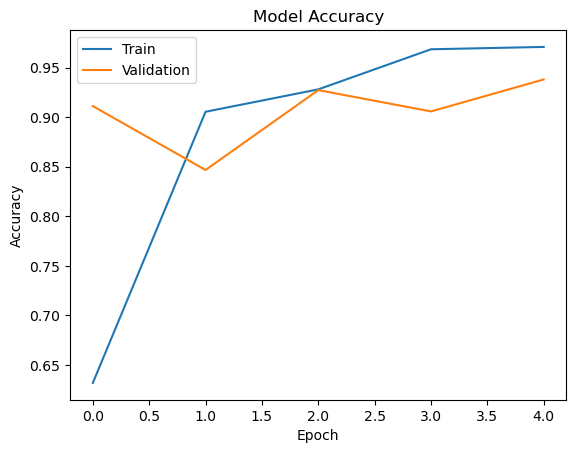

In [13]:

plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Description:
I experimented with LeakyreLU and relu and I noticed not much of a difference. The optimizer at first seemed to learn too quickly, so I decreased the learning rate. This seemed to slow down the rate at which the model learned and therefore helped prevent overfitting too soon. I also experimented with more convolutional layers, however this seemed to just make the learning rate increase. Data augmentation seemed to help the validation accuracy go up the most. In the end, I was able to get the validation accuracy to 94 percent.



